In [13]:
import numpy as np
from scipy import interpolate
from scipy.io import savemat
import matplotlib.pyplot as plt
import os

filepath = "data/rossrad.dat"
resolution = 0.0625
data = np.loadtxt("../assets/rossrad.dat")
x = data[:, 0]  # latitude
y = data[:, 1]  # longitude (0-360)
phase_speed = data[:, 2]  # phase speed (m/s)
rossby_radius = data[:, 3]  # Rossby radius (km)
# Convert longitude from 0-360 to -180-180
y[y > 180] = y[y > 180] - 360
lon_1d = np.arange(-180, 180, resolution)
lat_1d = np.arange(-80, 80, resolution)
lon, lat = np.meshgrid(lon_1d, lat_1d)
# Grid the data using scipy's griddata (MATLAB lines 24-25)
points = np.column_stack([x, y])
phase_speed = phase_speed * 3600 * 24 / 1000  # m/s to km/day

# Rd: Rossby radius in km (already in correct units)
rossby_radius = interpolate.griddata(points, rossby_radius, (lat, lon), method="linear", fill_value=np.nan)

# Vd: phase speed in km/day (MATLAB line 24)
# Convert from m/s to km/day: m/s * 3600*24/1000
phase_speed = interpolate.griddata(points, phase_speed, (lat, lon), method="linear", fill_value=np.nan)




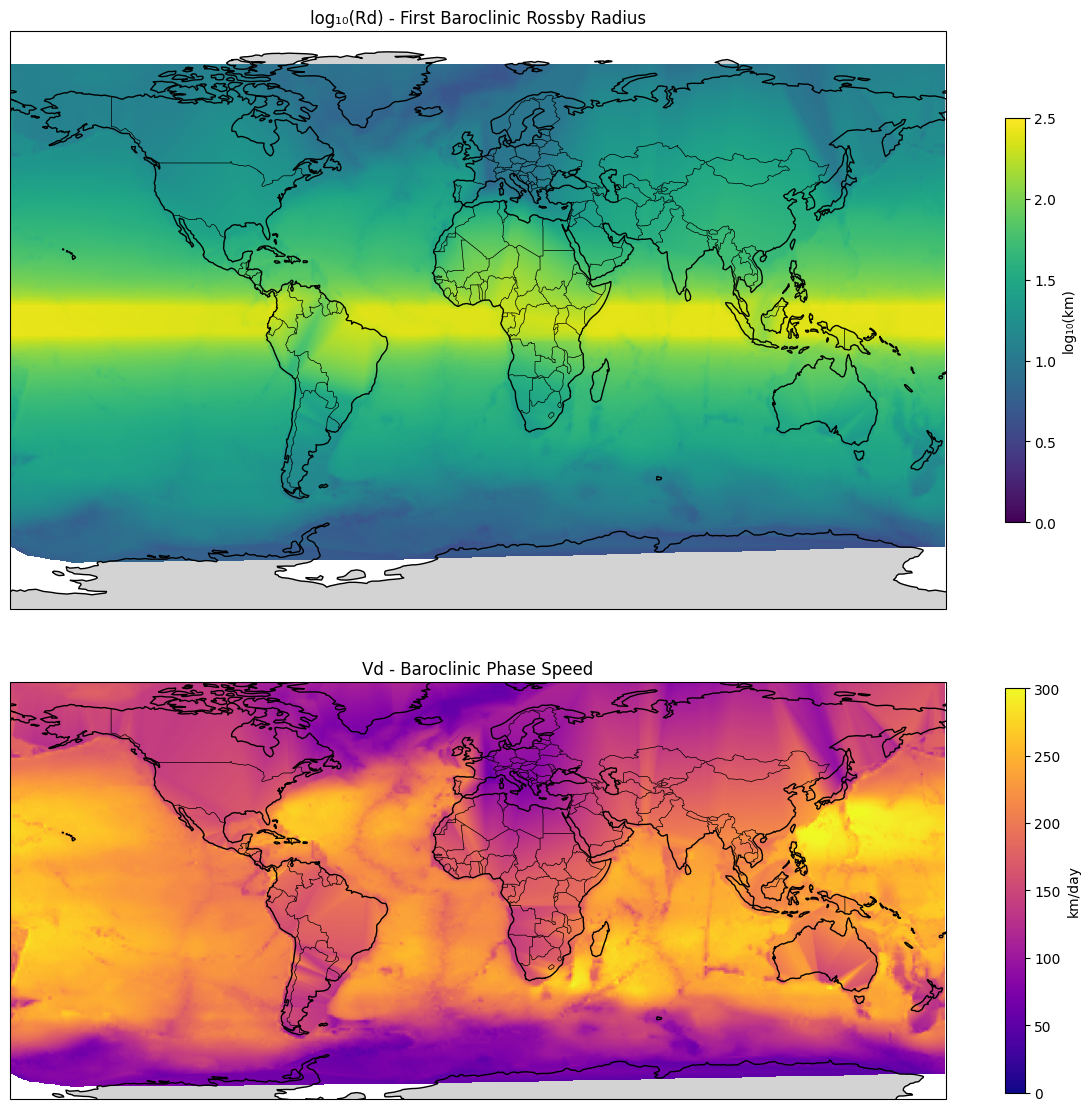

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Create figure with two map panels
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 12),
    subplot_kw={"projection": ccrs.PlateCarree()}
)


# ---- Plot log10(Rd) ----
im1 = ax1.pcolormesh(
    lon, lat, np.log10(rossby_radius),
    vmin=0, vmax=2.5, cmap="viridis", shading="auto",
    transform=ccrs.PlateCarree()
)
ax1.set_title("log₁₀(Rd) - First Baroclinic Rossby Radius")
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor="lightgray")
ax1.set_global()
ax1.set_aspect("auto")  # or "equal" depending on preference

cbar1 = plt.colorbar(im1, ax=ax1, orientation="vertical", shrink=0.7, pad=0.05)
cbar1.set_label("log₁₀(km)")

# ---- Plot Vd ----
im2 = ax2.pcolormesh(
    lon, lat, phase_speed,
    vmin=0, vmax=300, cmap="plasma", shading="auto",
    transform=ccrs.PlateCarree()
)
ax2.set_title("Vd - Baroclinic Phase Speed")
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor="lightgray")
ax1.set_global()
ax1.set_aspect("auto")  # or "equal" depending on preference


cbar2 = plt.colorbar(im2, ax=ax2, orientation="vertical", shrink=0.7, pad=0.05)
cbar2.set_label("km/day")

plt.tight_layout()
plt.show()


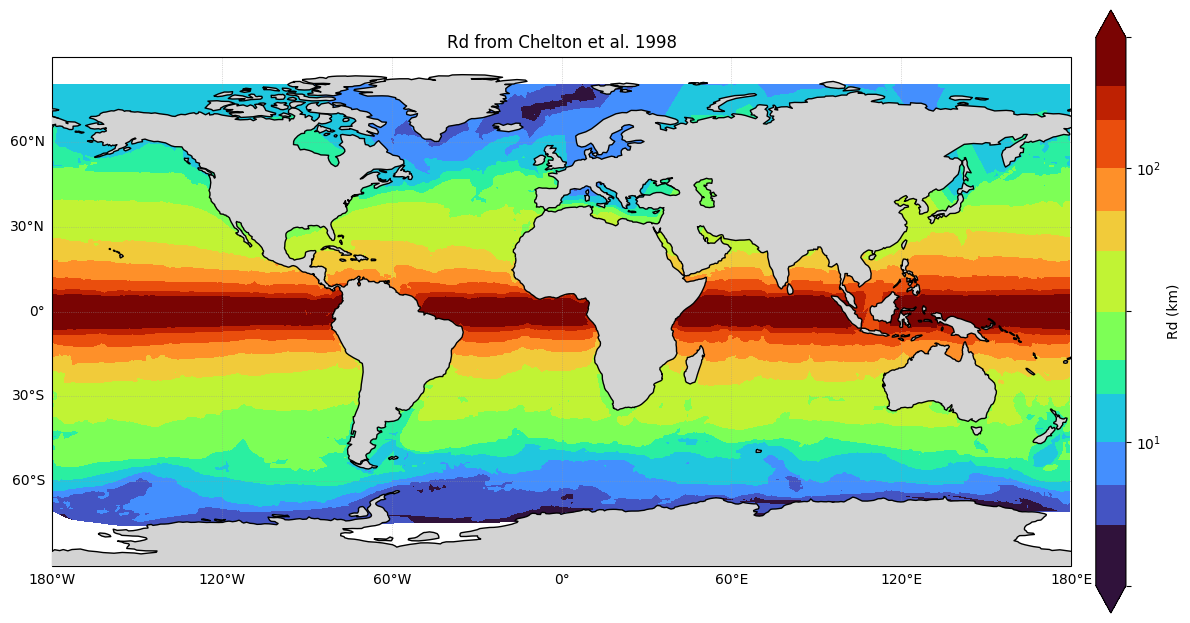

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import colors

Rd = np.ma.masked_invalid(rossby_radius)              # mask NaNs
Rd = np.ma.masked_less_equal(Rd, 0)                   # log-safe

# Log-spaced, discrete bands (tune as you like)
bounds = np.array([3, 5, 7, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300])
norm   = colors.LogNorm(vmin=bounds[0], vmax=bounds[-1])

# a rainbow-ish map similar to the paper (use 'turbo' or 'gist_rainbow_r' if you prefer)
cmap   = plt.get_cmap('turbo', len(bounds)-1)   # discrete colors

fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Filled contours with discrete, log-spaced levels
cf = ax.contourf(
    lon, lat, Rd,
    levels=bounds, norm=norm, cmap=cmap,
    transform=ccrs.PlateCarree(), extend='both'
)

# Land/coasts on top
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=10)
ax.coastlines(zorder=11)

# Gridlines with labels like the example
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='0.6',
                  alpha=0.7, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
gl.ylocator = plt.FixedLocator(np.arange(-60,  61, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Rd from Chelton et al. 1998')

# Colorbar with log ticks at decade values
cb = plt.colorbar(cf, ax=ax, pad=0.02, shrink=0.9,
                  ticks=[3, 10, 30, 100, 300])
cb.set_label('Rd (km)')

plt.tight_layout()
plt.show()


In [4]:
rossby_radius.shape

(2561, 5761)

In [17]:


# box you gave
min_lon, max_lon = -30.0625, -16.0625
min_lat, max_lat = 19.9375, 33.9375

# indices along each axis
ilat = (lat_1d >= min_lat) & (lat_1d < max_lat)
ilon = (lon_1d >= min_lon) & (lon_1d < max_lon)

# cropped coordinate vectors
lat_box = lat_1d[ilat]
lon_box = lon_1d[ilon]

# cropped data (same order as [lat, lon])
Rd_box = rossby_radius[np.ix_(ilat, ilon)]
Vd_box = phase_speed[np.ix_(ilat, ilon)]     # km/day

lon_sub, lat_sub = np.meshgrid(lon_box, lat_box)


In [18]:
Rd_box.shape

(224, 224)

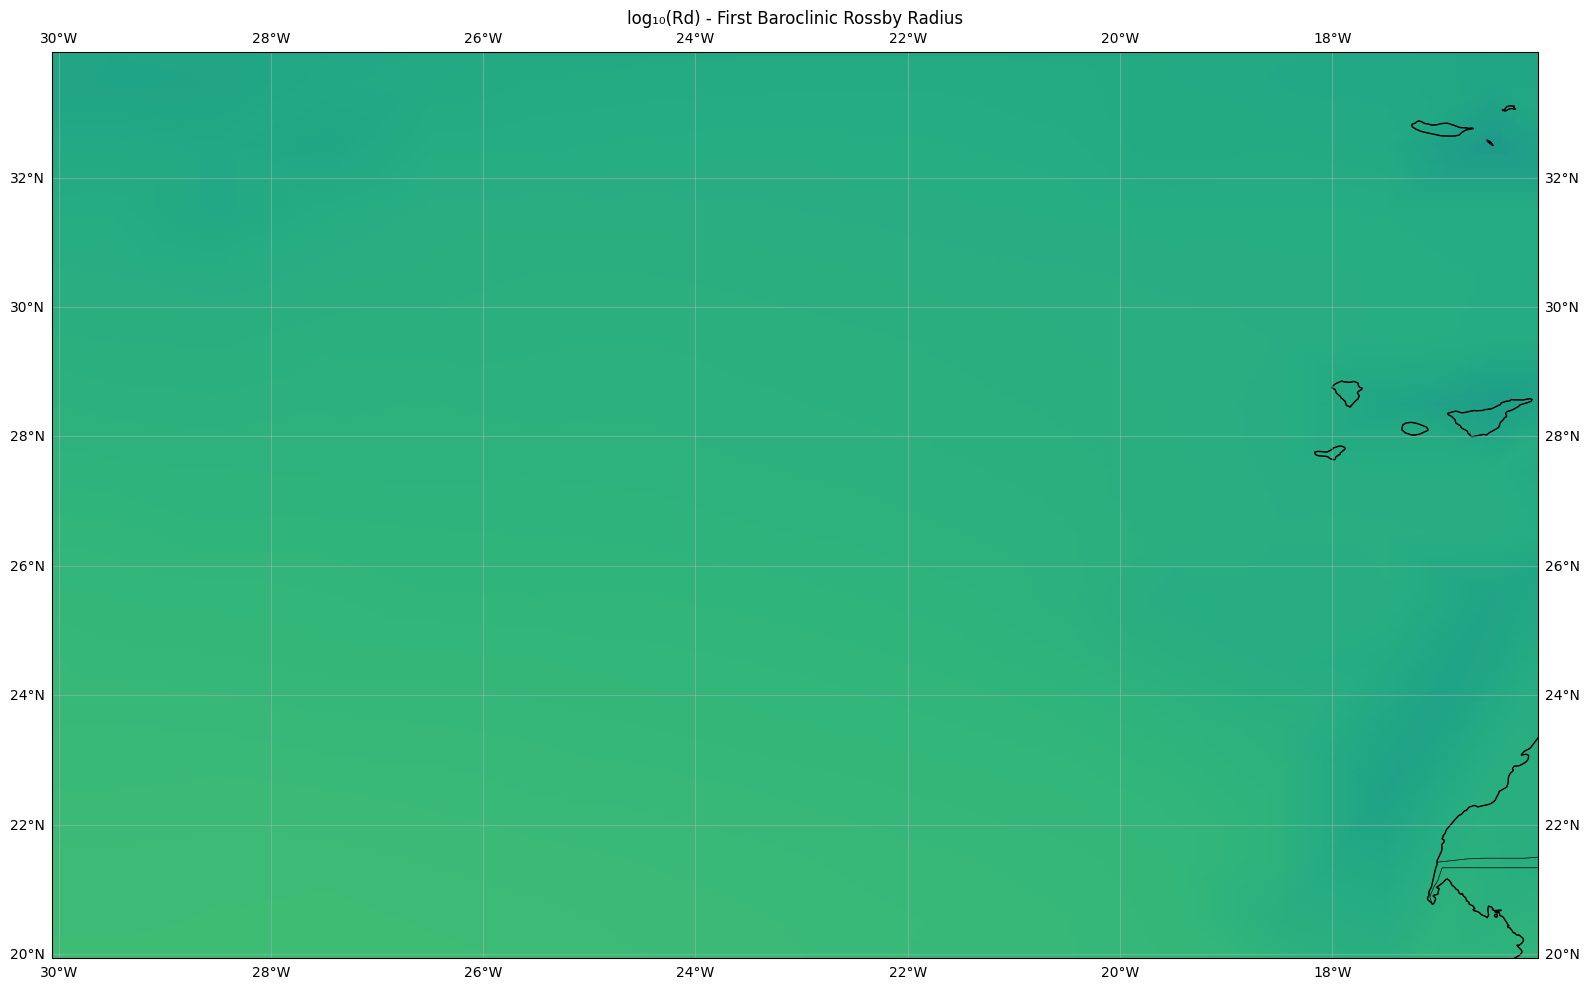

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import colors

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)

im = ax.pcolormesh(lon_sub, lat_sub, np.log10(Rd_box), transform=ccrs.PlateCarree(), cmap="viridis", vmin=0, vmax=2.5)
ax.set_title("log₁₀(Rd) - First Baroclinic Rossby Radius")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.set_extent([-30.0625, -16.0625, 19.9375, 33.9375], crs=ccrs.PlateCarree())
ax.set_aspect("auto")  # or "equal" depending on preference
plt.tight_layout()
plt.show()
